In [1]:
%load_ext autoreload
%autoreload 2

from datasets import DataCifar10
from models import LinearSoftmax
from optimers import OptimerSGD
from tuners import ParamTuner
from utils import check_accuracy, show_weight_images, show_training_info

import numpy as np

In [2]:
# load data
dataloader = DataCifar10('./datasets/cifar-10-batches-py', norm_dis_mean=True,
                         num_val=10000, num_train=40000, num_test=10000)
dataloader.show_info()

Training data shape:  (40000, 3, 32, 32)
Training labels shape:  (40000,)
Validating data shape:  (10000, 3, 32, 32)
Validating labels shape:  (10000,)
Testing data shape:  (10000, 3, 32, 32)
Testing labels shape:  (10000,)


# Sanity check

In [33]:
# sanity check
model = LinearSoftmax(32 * 32 * 3, 10, hyperparams={'reg': 0.0})
loss = model.backward(dataloader.x_train, dataloader.y_train)

print('Init loss is', loss)

Init loss is 2.3791275094104494


# Train model

In [7]:
# train model
model = LinearSoftmax(32 * 32 * 3, 10, hyperparams={'reg': 0.01})
optimer = OptimerSGD(hyperparams={'learn_rate': 1e-8, 'num_iters': 1000, 'batch_size': 500})

optimer.train(model, dataloader)

0 / 1000 loss is 2.4440022817133276
100 / 1000 loss is 2.304708519174883
200 / 1000 loss is 2.256294519533368
300 / 1000 loss is 2.210385162290554
400 / 1000 loss is 2.1821722066740272
500 / 1000 loss is 2.1368661636944726
600 / 1000 loss is 2.1459654901650143
700 / 1000 loss is 2.102736040387187
800 / 1000 loss is 2.112500831264639
900 / 1000 loss is 2.0876320169154874


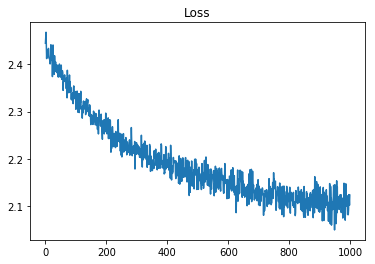

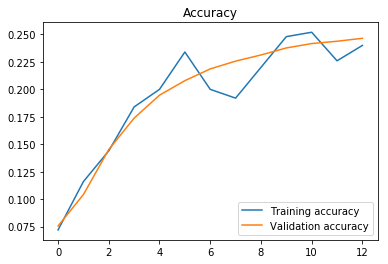

In [8]:
# plot loss curve
show_training_info(optimer)

In [9]:
# check accuracy
scores = model.predict(dataloader.x_test)
accuracy = check_accuracy(scores, dataloader.y_test)
    
print('The accuracy on testing dataset is ', accuracy)

The accuracy on testing dataset is  0.2514


# Tune model

In [14]:
def get_model(hyperparams):
    return LinearSoftmax(32 * 32 * 3, 10, hyperparams=hyperparams)

# tune hyperparameters
tuner = ParamTuner(get_model, OptimerSGD, dataloader)
model_best, param_best, acc_best = tuner.tune({'reg': 0.01, 'learn_rate': 5e-9, 'num_iters': 1000, 'batch_size': 500}, 
                                              {'reg': [0.001, 0.01, 0.1, 1, 10], 
                                               'learn_rate': [1e-10, 5e-10, 1e-9, 5e-9, 1e-8, 5e-8],
                                               'num_iters': [500, 1000, 1500, 2000, 2500, 3000]}, epoch=2)
# {'reg': 0.001, 'learn_rate': 5e-09, 'num_iters': 1000, 'batch_size': 500}

Tune reg in [0.001, 0.01, 0.1, 1, 10]
With {'reg': 0.001, 'learn_rate': 5e-09, 'num_iters': 1000, 'batch_size': 500} accuracy: 0.4014  - Best!
With {'reg': 0.01, 'learn_rate': 5e-09, 'num_iters': 1000, 'batch_size': 500} accuracy: 0.4058  - Best!
With {'reg': 0.1, 'learn_rate': 5e-09, 'num_iters': 1000, 'batch_size': 500} accuracy: 0.4039
With {'reg': 1, 'learn_rate': 5e-09, 'num_iters': 1000, 'batch_size': 500} accuracy: 0.4023
With {'reg': 10, 'learn_rate': 5e-09, 'num_iters': 1000, 'batch_size': 500} accuracy: 0.3996
Tune learn_rate in [1e-10, 5e-10, 1e-09, 5e-09, 1e-08, 5e-08]
With {'reg': 0.01, 'learn_rate': 1e-10, 'num_iters': 1000, 'batch_size': 500} accuracy: 0.3502
With {'reg': 0.01, 'learn_rate': 5e-10, 'num_iters': 1000, 'batch_size': 500} accuracy: 0.3938
With {'reg': 0.01, 'learn_rate': 1e-09, 'num_iters': 1000, 'batch_size': 500} accuracy: 0.4013
With {'reg': 0.01, 'learn_rate': 5e-09, 'num_iters': 1000, 'batch_size': 500} accuracy: 0.4051
With {'reg': 0.01, 'learn_rate':

In [15]:
# check accuracy
scores = model_best.predict(dataloader.x_test)
accuracy = check_accuracy(scores, dataloader.y_test)
    
print('The best hyperparameter is ', param_best)
print('The best accuracy on validating dataset is ', acc_best)
print('The accuracy on testing dataset is ', accuracy)

The best hyperparameter is  {'reg': 0.001, 'learn_rate': 5e-09, 'num_iters': 1000, 'batch_size': 500}
The best accuracy on validating dataset is  0.4089
The accuracy on testing dataset is  0.4014


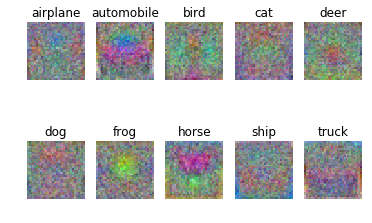

In [16]:
# show weight image
show_weight_images(model_best.params['W'], 32, dataloader.label_names)